In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, LeaveOneOut, StratifiedKFold, cross_val_score, learning_curve, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import random
import glob
import os


import warnings
warnings.filterwarnings('ignore')

In [2]:
X = pd.read_csv("./engine/engineInputs.csv", header=None)
X = X.transpose()
X.rename(columns={0:'X1', 1:'X2'}, inplace=True)
X.head()

,X1,X2
0,17.5,576.2
1,35.9,598.6
2,31.4,612.1
3,23.7,624.2
4,20.2,635.2


In [3]:
y = pd.read_csv("./engine/engineTargets.csv", header=None)
y = y.transpose()
y.rename(columns={0:'y1', 1:'y2'}, inplace=True)
y.head()

,y1,y2
0,57.6,848.0
1,24.8,905.0
2,22.3,578.0
3,15.6,382.0
4,16.5,298.0


In [4]:
engine = pd.concat([X, y], axis=1)
engine.head()

,X1,X2,y1,y2
0,17.5,576.2,57.6,848.0
1,35.9,598.6,24.8,905.0
2,31.4,612.1,22.3,578.0
3,23.7,624.2,15.6,382.0
4,20.2,635.2,16.5,298.0


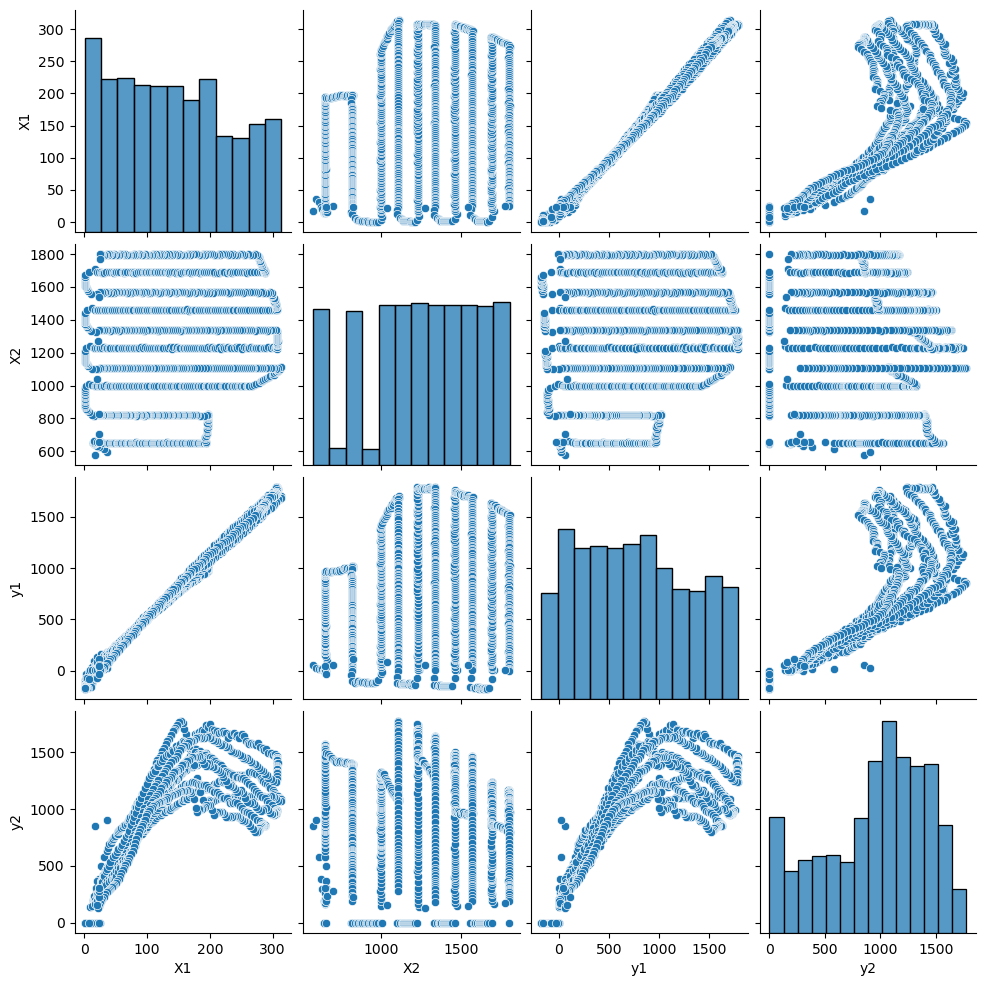

In [5]:
sns.pairplot(engine)
plt.show()

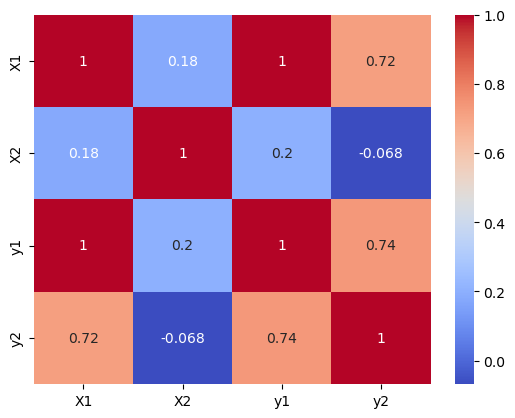

In [6]:
sns.heatmap(engine.corr(), annot=True, cmap='coolwarm')
plt.show()

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
def build_nn_model(input_dim):
    model = Sequential()

    # Input Layer
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Hidden Layer 1
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # Hidden Layer 2
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Hidden Layer 3
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Hidden Layer 4
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    # Output Layer
    model.add(Dense(2, activation='linear'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

    return model


Elastic_net scores:
   r2: 0.7480
   mean_squared_error: 55410.8833
   root_mean_squared_error: 235.1474
   median_absolute_error: 154.4074
   mean_absolute_error: 172.2473


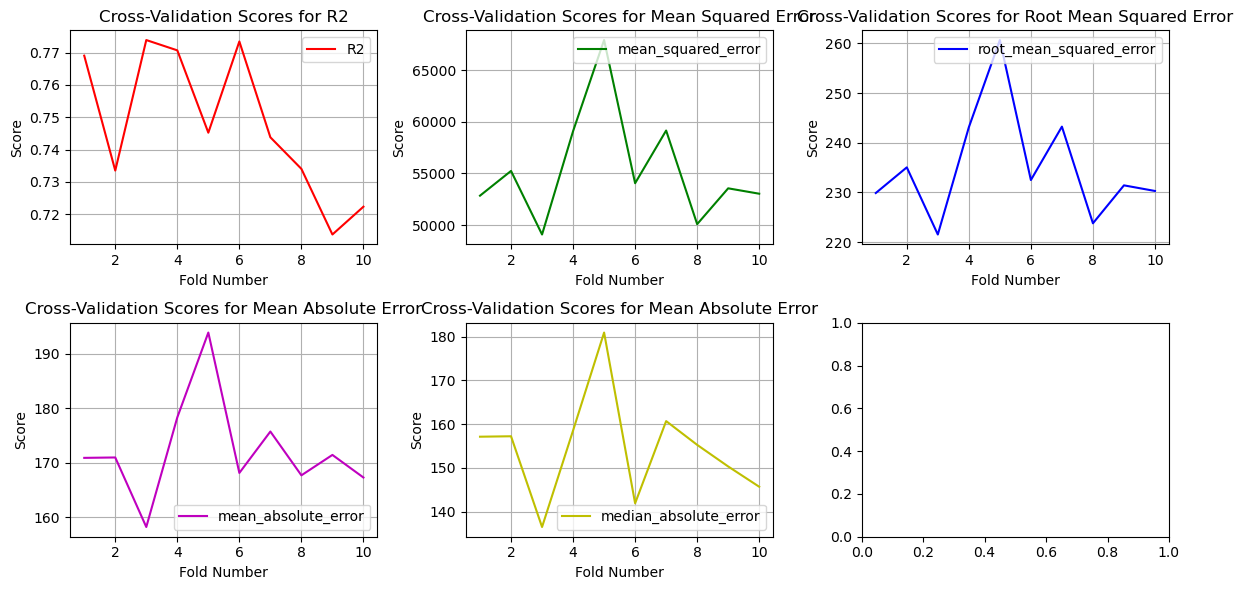

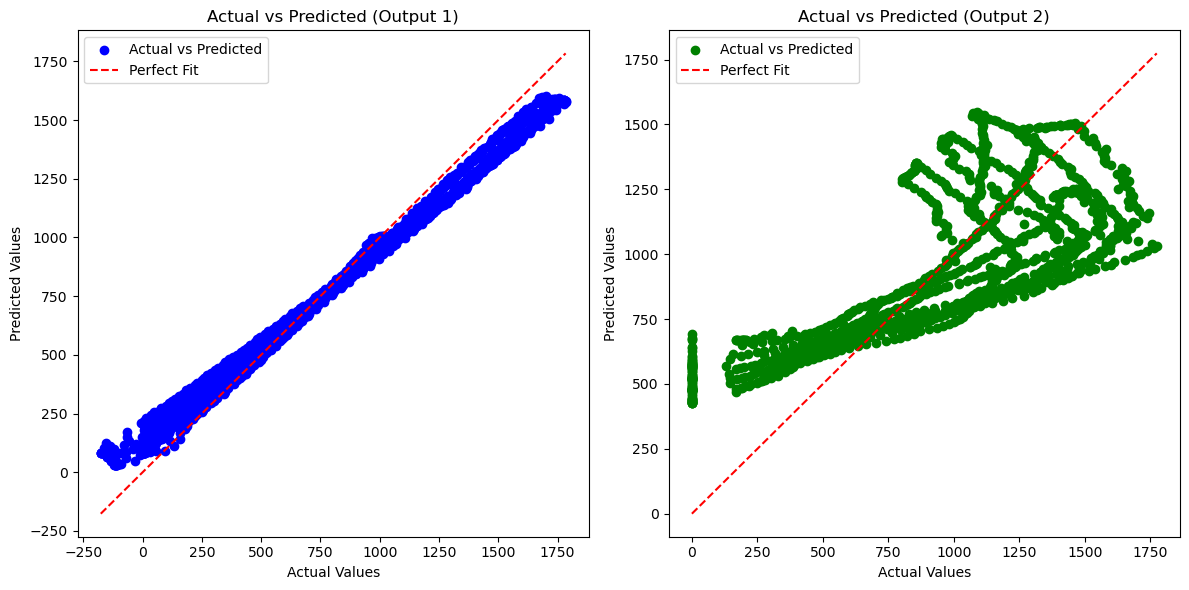

Overall R2 score on full dataset:  0.7537935942737575

Random_forest scores:
   r2: 0.9960
   mean_squared_error: 921.8578
   root_mean_squared_error: 28.9145
   median_absolute_error: 10.9008
   mean_absolute_error: 16.5185


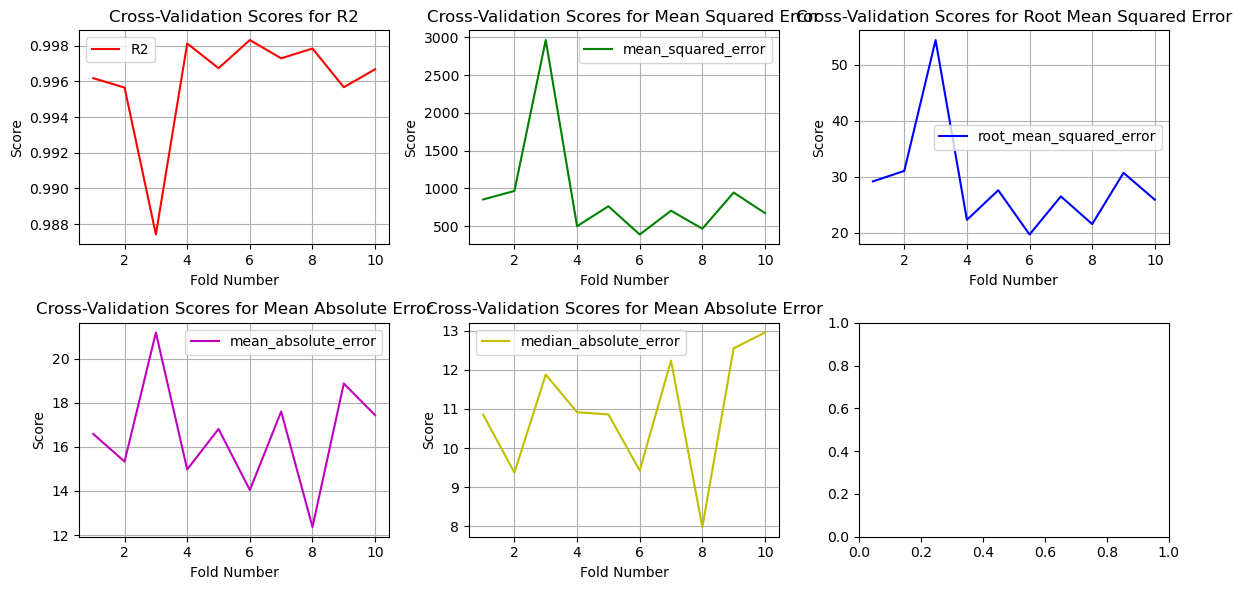

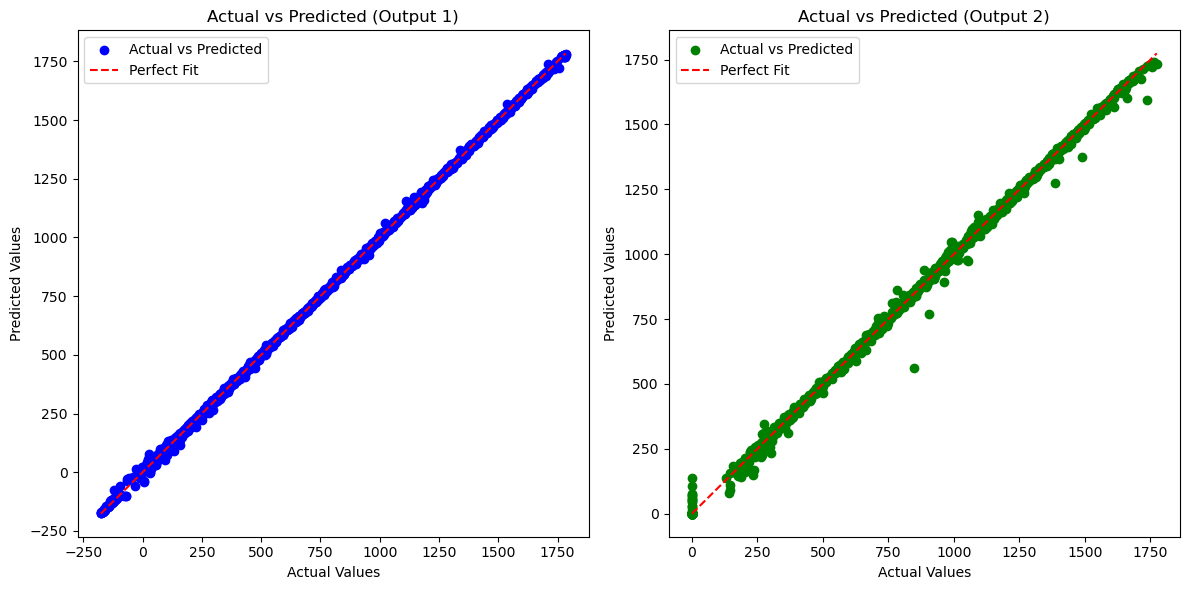

Overall R2 score on full dataset:  0.9990811923769924

Neural network scores:
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x1677813a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━

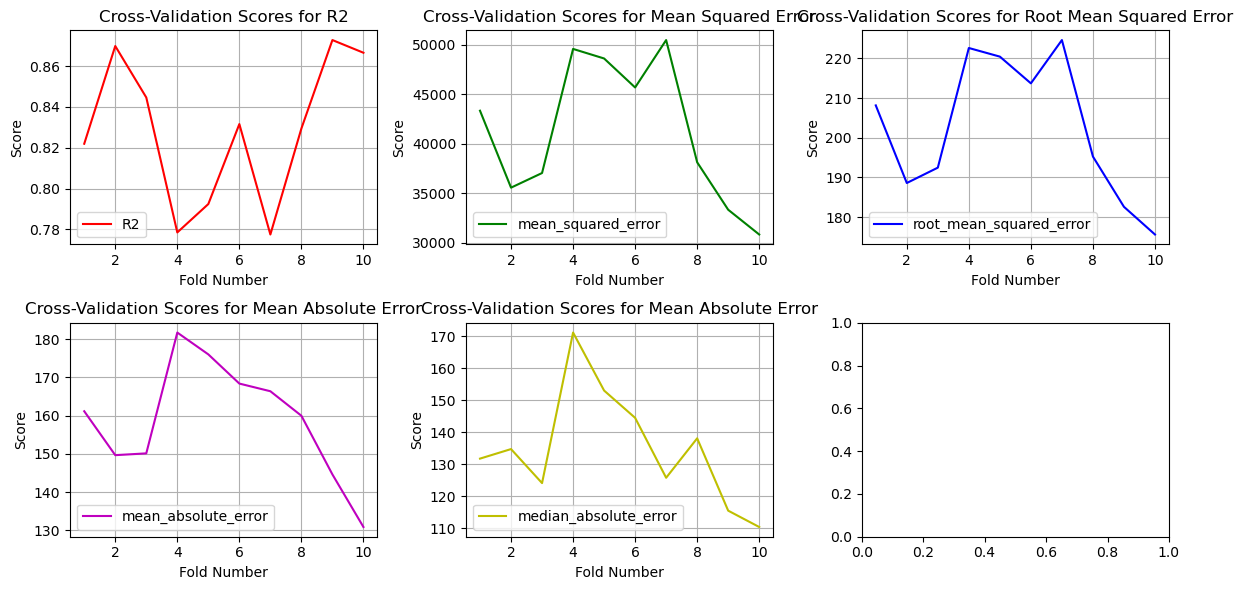

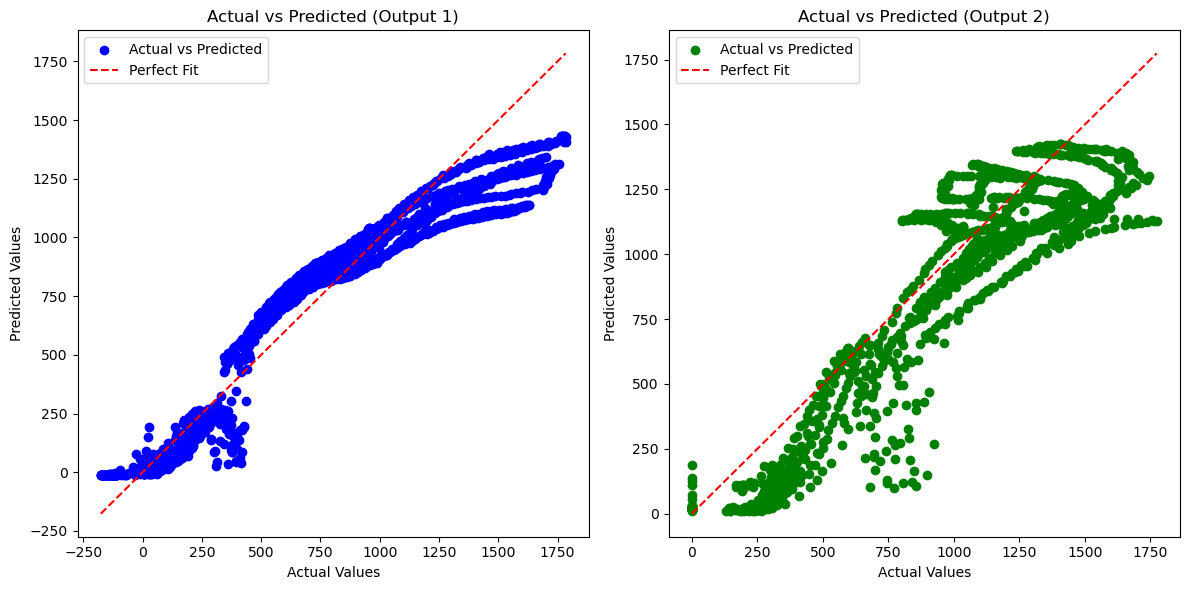

Overall R2 score on full dataset:  0.836985319569296


In [9]:
scores = ['r2', 'mean_squared_error', 'root_mean_squared_error', 'median_absolute_error', 'mean_absolute_error']
cv = KFold(n_splits=10, shuffle=True)

# Define regressors
regressors = {
    "Elastic_net": ElasticNet(alpha=0.4),
    "Random_forest": RandomForestRegressor(),
    "Neural network": "Keras"
}

# Iterate through each regressor
for regressor_name, model in regressors.items():
    print(f'\n{regressor_name} scores:')
    
    # Initialize storage for metric results
    metric_results = {score: [] for score in scores}
    fold_models = []  # Reset fold models for each regressor

    # Perform manual KFold cross-validation
    for train_idx, test_idx in cv.split(X):
        # Split the data
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Handle Keras model separately to create a fresh instance each time
        if model == "Keras":
            keras_model = build_nn_model(input_dim=X_train.shape[1])
            keras_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
            y_pred = keras_model.predict(X_test)  # Flatten to 1D array
            fold_models.append(keras_model)
        else:
            # For scikit-learn models
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            fold_models.append(model)

        # Calculate and store each metric manually
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        medae = median_absolute_error(y_test, y_pred)

        # Store the scores (negate where necessary to match cross_val_score convention)
        metric_results['r2'].append(r2)
        metric_results['mean_squared_error'].append(mse)
        metric_results['root_mean_squared_error'].append(rmse)
        metric_results['mean_absolute_error'].append(mae)
        metric_results['median_absolute_error'].append(medae)

    # Display average scores
    for score in scores:
        mean_score = np.mean(metric_results[score])
        print(f'   {score}: {mean_score:.4f}')

    # Select a random model from this regressor's folds
    random_model = random.choice(fold_models)
    if regressor_name == "Neural Network (Keras)":
        y_hat = random_model.predict(X_scaled)
    else:
        y_hat = random_model.predict(X_scaled)
    
    # Plot cross-validation scores
    fig, ax = plt.subplots(2, 3, figsize=(12, 6))

    # Plotting only R2 in the second subplot
    ax[0,0].plot(
        range(1, len(metric_results['r2']) + 1),
        metric_results['r2'],
        label='R2',
        color='r'
    )
    ax[0,0].set_title("Cross-Validation Scores for R2")
    ax[0,0].set_xlabel("Fold Number")
    ax[0,0].set_ylabel("Score")
    ax[0,0].legend(loc="best")
    ax[0,0].grid(True)
    
    ax[0,1].plot(
        range(1, len(metric_results['mean_squared_error']) + 1),
        metric_results['mean_squared_error'],
        label='mean_squared_error',
        color='g'
    )
    ax[0,1].set_title("Cross-Validation Scores for Mean Squared Error")
    ax[0,1].set_xlabel("Fold Number")
    ax[0,1].set_ylabel("Score")
    ax[0,1].legend(loc="best")
    ax[0,1].grid(True)

    ax[0,2].plot(
        range(1, len(metric_results['mean_squared_error']) + 1),
        metric_results['root_mean_squared_error'],
        label='root_mean_squared_error',
        color='b'
    )
    ax[0,2].set_title("Cross-Validation Scores for Root Mean Squared Error")
    ax[0,2].set_xlabel("Fold Number")
    ax[0,2].set_ylabel("Score")
    ax[0,2].legend(loc="best")
    ax[0,2].grid(True)

    ax[1,0].plot(
        range(1, len(metric_results['mean_absolute_error']) + 1),
        metric_results['mean_absolute_error'],
        label='mean_absolute_error',
        color='m'
    )
    ax[1,0].set_title("Cross-Validation Scores for Mean Absolute Error")
    ax[1,0].set_xlabel("Fold Number")
    ax[1,0].set_ylabel("Score")
    ax[1,0].legend(loc="best")
    ax[1,0].grid(True)

    ax[1,1].plot(
        range(1, len(metric_results['median_absolute_error']) + 1),
        metric_results['median_absolute_error'],
        label='median_absolute_error',
        color='y'
    )
    ax[1,1].set_title("Cross-Validation Scores for Mean Absolute Error")
    ax[1,1].set_xlabel("Fold Number")
    ax[1,1].set_ylabel("Score")
    ax[1,1].legend(loc="best")
    ax[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Scatter plot for the first output
    axes[0].scatter(y.iloc[:, 0], y_hat[:, 0], color='blue', label='Actual vs Predicted')
    axes[0].plot([y.iloc[:, 0].min(), y.iloc[:, 0].max()], [y.iloc[:, 0].min(), y.iloc[:, 0].max()], 'r--', label='Perfect Fit')
    axes[0].set_xlabel('Actual Values')
    axes[0].set_ylabel('Predicted Values')
    axes[0].set_title('Actual vs Predicted (Output 1)')
    axes[0].legend()
    
    # Scatter plot for the second output
    axes[1].scatter(y.iloc[:, 1], y_hat[:, 1], color='green', label='Actual vs Predicted')
    axes[1].plot([y.iloc[:, 1].min(), y.iloc[:, 1].max()], [y.iloc[:, 1].min(), y.iloc[:, 1].max()], 'r--', label='Perfect Fit')
    axes[1].set_xlabel('Actual Values')
    axes[1].set_ylabel('Predicted Values')
    axes[1].set_title('Actual vs Predicted (Output 2)')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


    
    # Adding labels and grid
    print("Overall R2 score on full dataset: ", r2_score(y, y_hat))